In [1]:
import numpy as np
import torch
import os
import pickle
import matplotlib.pyplot as plt
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (20, 20)
# plt.rcParams['image.interpolation'] = 'bilinear'

from argparse import ArgumentParser

from torch.optim import SGD, Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor, ToPILImage
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import lr_scheduler
from networks.UNet_check import UNet_check
# from networks.UNet_check import UNet_check
# from networks.SegNet_standard import SegNet

import collections
import numbers
import random
import math
from PIL import Image, ImageOps, ImageEnhance
import logging
import time
import tool
# import bcolz

In [2]:
CROSS_VALIDATION_FOLD = 0 # 0-4
SEED = CROSS_VALIDATION_FOLD * 100
NUM_CHANNELS = 3
NUM_CLASSES = 2 
model_name = 'UNet_check'
log_path = 'log/'
save_weights_path = '../_weights/'
if not os.path.exists(save_weights_path):
    os.makedirs(save_weights_path)
if not os.path.exists(log_path):
    os.makedirs(log_path)

In [3]:
log_filename = log_path + model_name + '-fold'+str(CROSS_VALIDATION_FOLD)+'.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, 
                   format='%(asctime)s:%(levelname)s:%(message)s')
def log(message):
    print(message)
    logging.info(message)

In [4]:
log('='*50 + 'start run' + '='*50)

==================================================start run==================================================


## dataset

In [5]:
# NUM_CHANNELS = 3
# NUM_CLASSES = 2 # car is 1, background is 0

# color_transform = Colorize(n=NUM_CLASSES)
# image_transform = ToPILImage()

In [6]:
# class Crop_different_size_for_image_and_label(object):
#     def __init__(self, image_size=572, label_size=388):
#         self.image_size = image_size
#         self.label_size = label_size
#         self.bound = (self.image_size - self.label_size) // 2

#     def __call__(self, img_and_label):
#         img, label = img_and_label
#         w, h = img.size
        
#         xcenter = 1000
#         ycenter = 600
        
#         img = img.crop((xcenter - self.image_size // 2, ycenter - self.image_size // 2, xcenter + self.image_size // 2, ycenter + self.image_size // 2))
#         label = label.crop((xcenter - self.label_size // 2, ycenter - self.label_size // 2, xcenter + self.label_size // 2, ycenter + self.label_size // 2))
        
#         return img, label

In [7]:
# random_rotate = tool.Random_Rotate_Crop(maxAngle = 10)
# crop = tool.Random_Rotate_Crop(maxAngle = 0)
# crop_512 = tool.RandomCrop(crop_size = 512)
crop_572 = tool.RandomCrop_different_size_for_image_and_label(image_size=572, label_size=388)
# random_color = tool.RandomColor()
to_tensor_label = tool.ToTensor_Label()
normalize = tool.ImageNormalize([.485, .456, .406], [.229, .224, .225])
train_transforms = tool.Compose([crop_572, to_tensor_label, normalize])
val_transforms = tool.Compose([crop_572, to_tensor_label, normalize])

In [8]:
image_path = '../../data/images/train/'
mask_path = '../../data/images/train_masks/'

In [9]:
with open('./train_shuffle_names.pk', 'rb') as f:
    filenames = pickle.load(f)

In [10]:
fold_num = len(filenames) // 5
folds = []
for i in range(5):
    if i == 4:
        folds.append(filenames[i * fold_num :])
    else:
        folds.append(filenames[i * fold_num : (i + 1) * fold_num])

train_filenames = []
for i in range(5):
    if i == CROSS_VALIDATION_FOLD:
        val_filenames = folds[i]
    else:
        train_filenames += folds[i]

In [11]:
# train_filenames = train_filenames[:4]
# val_filenames = val_filenames[:1]

In [49]:
train_set = tool.Car_dataset(image_path, mask_path, train_filenames[:100], train_transforms, ifFlip=True) 
val_set = tool.Car_dataset(image_path, mask_path, train_filenames[:100], val_transforms, ifFlip=True) # for validation set
train_loader = DataLoader(train_set, num_workers=4, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, num_workers=4, batch_size=4, shuffle=False) # for validation set

## dataset examples

In [28]:
inp, tar = val_loader.__iter__().next()

In [29]:
i = 1
inp = Variable(inp)
tar = Variable(tar)
# tar[:, 0]
t = tar[i].cpu().data.numpy()
inpu = inp[i].cpu().data.numpy()

In [30]:
img_tensor = inp[i]
for ten, m, s in zip(img_tensor, [.229, .224, .225], [.485, .456, .406]):
    ten.mul_(m).add_(s)
img = ToPILImage()(img_tensor)

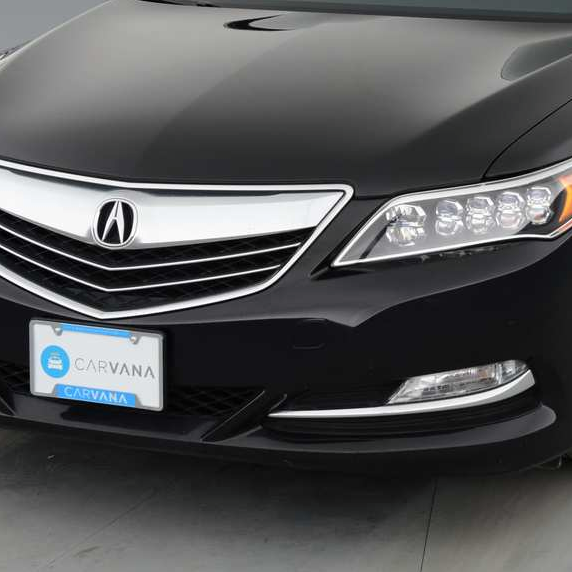

In [31]:
img

In [32]:
b = (572-388)//2

In [33]:
img = img.crop((b, b, b + 388, b + 388))

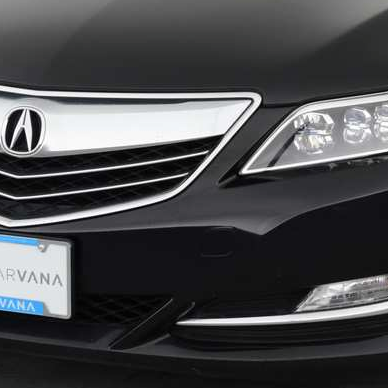

In [34]:
img

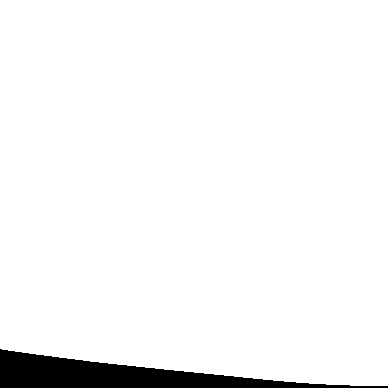

In [35]:
label = Image.fromarray(t[0].astype('uint8') * 255)
label

## train

In [21]:
def load_model(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    
def save_model(filename, model, optimizer):
    torch.save({'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict()}, 
                filename)

In [133]:
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True, reduce=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.loss = nn.NLLLoss(weight, size_average, reduce=reduce)

    def forward(self, outputs, targets):
        return self.loss(F.log_softmax(outputs, dim=1), targets)

In [38]:
def train(epoch, steps_plot=0):
    model.train()

    weight = torch.ones(NUM_CLASSES)
    criterion = CrossEntropyLoss2d(weight.cuda()) # loss function

    epoch_loss = []
    step_loss = []

    for step, (images, labels) in enumerate(train_loader):
        
        images = images.cuda()
        labels = labels.cuda()

        inputs = Variable(images)
        targets = Variable(labels)
        outputs = model(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs, targets[:, 0])
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        step_loss.append(loss.item())
        
        if step % 10 == 0:
            average_step_loss = sum(step_loss) / len(step_loss)
            message = 'Epoch[{}]({}/{}): \tloss: {:.4}'.format(epoch, step, len(train_loader), average_step_loss)
            log(message)
            step_loss = []
    average = sum(epoch_loss) / len(epoch_loss)
    message = 'Train: Epoch[{}] \taverage loss: {:.4}'.format(epoch, average)
    log(message)
    return average

In [39]:
def test(steps_plot = 0):
    with torch.no_grad():
        model.eval()

        weight = torch.ones(NUM_CLASSES)
        criterion = CrossEntropyLoss2d(weight.cuda())

        total_loss = []

        for step, (images, labels) in enumerate(val_loader):

            images = images.cuda()
            labels = labels.cuda()

            inputs = Variable(images)
            targets = Variable(labels)
            outputs = model(inputs)

            loss = criterion(outputs, targets[:, 0])

            total_loss.append(loss.item())

        average = sum(total_loss) / len(total_loss)
        message = 'Validation: \taverage loss: {:.4}'.format(average)
        log(message)
        return average

## train


In [25]:
torch.cuda.manual_seed_all(SEED)
model = UNet_check()
model = model.cuda()
optimizer = Adam(model.parameters(), lr = 1e-3)

# load_model('save_model_test.pth', model, optimizer)

In [26]:
load_model('../_weights/'+'UNet_check-fold0-111900.01597.pth', model, optimizer)


In [36]:
try_loss = test()

Validation: 	average loss: 2.586e+04


In [41]:
train(51)

Epoch[51](0/25): 	loss: 0.009111
Epoch[51](10/25): 	loss: 0.009088
Epoch[51](20/25): 	loss: 0.008877
Train: Epoch[51] 	average loss: 0.008573


0.008572832364588976

In [69]:
epoch = 51
model.train()

weight = torch.ones(NUM_CLASSES)
criterion = CrossEntropyLoss2d(weight.cuda()) # loss function

for step, (images, labels) in enumerate(val_loader):

    images = images.cuda()
    labels = labels.cuda()

    inputs = Variable(images)
    targets = Variable(labels)
    outputs = model(inputs)

    optimizer.zero_grad()
    loss = criterion(outputs, targets[:, 0])
    loss.backward()
    optimizer.step()

    print(loss.item())
average = sum(epoch_loss) / len(epoch_loss)

0.008843899704515934
0.01149776577949524
0.009810145944356918
0.005076394882053137
0.005010565277189016
0.006944386754184961
0.005031321197748184
0.010117295198142529
0.004598962143063545
0.011023430153727531
0.005571386311203241
0.007803214248269796
0.004163944628089666
0.011904184706509113
0.006324866320937872
0.006760204676538706
0.00395430251955986
0.0014977502869442105
0.004036635160446167
0.007655196823179722
0.01021955069154501
0.008787493221461773
0.01631738431751728
0.004892656113952398
0.013848970644176006


In [81]:
with torch.no_grad():
    model.eval()

    weight = torch.ones(NUM_CLASSES)
    criterion = CrossEntropyLoss2d(weight.cuda())

    for step, (images, labels) in enumerate(val_loader):

        images = images.cuda()
        labels = labels.cuda()

        inputs = Variable(images)
        targets = Variable(labels)
        outputs = model(inputs)

        loss = criterion(outputs, targets[:, 0])
        if loss > 10:
            break
        print(loss.item())
        

0.00730355316773057
0.005479287821799517
0.013597121462225914
0.007238209713250399
0.005886507220566273
0.0033288891427218914
0.0059247734025120735
0.008777979761362076


In [156]:
input_images = inputs.cpu().data.numpy()
target_images = targets.cpu().data.numpy()
output_images = outputs.cpu().data.numpy()
# output_images = np.argmax(output_images, axis=1)

In [100]:
input_images_denorm = np.zeros((input_images.shape))
for i, input_image in enumerate(input_images):
    for j, (chan, m, s) in enumerate(zip(input_image, [.229, .224, .225], [.485, .456, .406])):
        chan = chan * m + s
        input_images_denorm[i, j] = chan
input_images_denorm = input_images_denorm.transpose(0, 2, 3, 1)

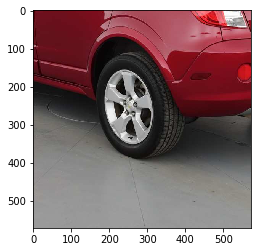

In [126]:
idx = 2
plt.imshow(input_images_denorm[idx])

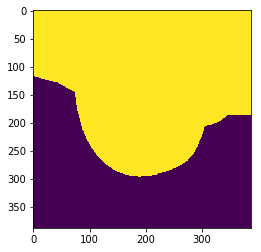

In [127]:
plt.imshow(target_images[idx, 0])

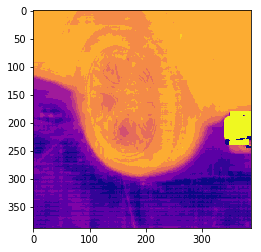

In [174]:
plt.imshow(output_images[idx, 1], vmin=-8, vmax=8, cmap='plasma')

In [171]:
output_images[idx, 1]

array([[ 5.1741276,  5.121849 ,  5.216349 , ...,  5.0050073,  5.05593  ,
         5.096003 ],
       [ 5.2544627,  5.1888504,  5.304315 , ...,  4.969572 ,  5.086655 ,
         5.0579953],
       [ 5.2281914,  5.203226 ,  5.2966356, ...,  4.9542346,  5.0165653,
         5.0257735],
       ...,
       [-4.7141223, -4.7216334, -4.8210244, ..., -5.329498 , -5.3836713,
        -5.3906507],
       [-5.1668253, -5.2666354, -5.234736 , ..., -6.2663074, -5.9521337,
        -5.860536 ],
       [-5.2964287, -5.3235636, -5.328195 , ..., -6.1626678, -5.76242  ,
        -5.5728493]], dtype=float32)

(array([1.50407e+05, 6.20000e+01, 3.20000e+01, 1.70000e+01, 1.30000e+01,
        3.00000e+00, 4.00000e+00, 4.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([-2.99772793e+04,  2.03470204e+07,  4.07240182e+07,  6.11010159e+07,
         8.14780136e+07,  1.01855011e+08,  1.22232009e+08,  1.42609007e+08,
         1.62986005e+08,  1.83363002e+08,  2.03740000e+08]),
 <a list of 10 Patch objects>)

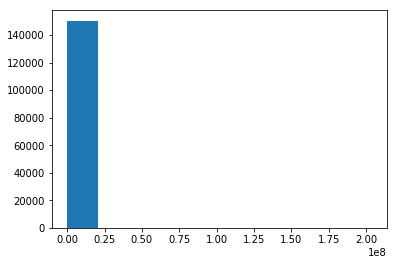

In [164]:
plt.hist(output_images[idx, 1].flatten())

In [157]:
output_images.shape

(4, 2, 388, 388)

In [ ]:
idx = 0
loss = criterion(outputs[idx], targets[idx, 0])

In [125]:
with torch.no_grad():
    for idx in range(4):
        loss = criterion(outputs[idx:idx+1], targets[idx:idx+1, 0])
        print(loss)

tensor(1.00000e-03 *
       3.8511, device='cuda:0')
tensor(1.00000e-02 *
       1.4874, device='cuda:0')
tensor(1.1790e+05, device='cuda:0')
tensor(1.00000e-02 *
       1.3326, device='cuda:0')


In [134]:
celll = CrossEntropyLoss2d(None, False, reduce=False)

In [135]:
with torch.no_grad():
    l = celll(outputs[2:3], targets[2:3, 0])

In [140]:
ll = l.cpu().data.numpy()[0]

In [141]:
ll

array([[3.7670135e-05, 4.1961670e-05, 3.4809113e-05, ..., 5.2452087e-05,
        4.7206879e-05, 4.3869019e-05],
       [3.2424927e-05, 3.6716461e-05, 2.9563904e-05, ..., 5.5789948e-05,
        4.3869019e-05, 4.6730042e-05],
       [3.3855438e-05, 3.5762787e-05, 2.9563904e-05, ..., 5.7697296e-05,
        5.0544739e-05, 5.0067902e-05],
       ...,
       [6.3419342e-05, 6.2465668e-05, 5.1498413e-05, ..., 1.8119812e-05,
        1.6212463e-05, 1.5735626e-05],
       [2.5749207e-05, 2.0980835e-05, 2.2411346e-05, ..., 2.8610229e-06,
        5.2452087e-06, 6.1988831e-06],
       [1.9550323e-05, 1.8119812e-05, 1.8119812e-05, ..., 3.3378601e-06,
        7.6293945e-06, 1.0967255e-05]], dtype=float32)

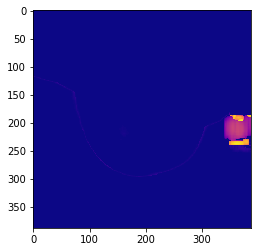

In [155]:
plt.imshow(np.log(ll+1), cmap='plasma')

(array([1.50408e+05, 6.10000e+01, 3.20000e+01, 1.80000e+01, 1.20000e+01,
        3.00000e+00, 4.00000e+00, 4.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([0.00000000e+00, 3.93647808e+07, 7.87295616e+07, 1.18094342e+08,
        1.57459123e+08, 1.96823904e+08, 2.36188685e+08, 2.75553466e+08,
        3.14918246e+08, 3.54283027e+08, 3.93647808e+08]),
 <a list of 10 Patch objects>)

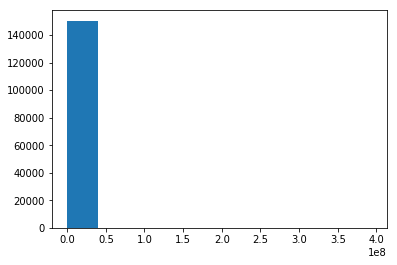

In [149]:
plt.hist(ll.flatten())

In [148]:
ll.flatten().shape

(150544,)

In [138]:
ll.shape

(1, 388, 388)

In [ ]:
save_weights_path = '../_weights/'
scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.5)
val_losses = []
start_time = time.time()
epoch_num = 300
for epoch in range(epoch_num):
    scheduler.step(epoch)
    message = 'learning rate: ' + str(scheduler.get_lr()[0])
    log(message)
    train(epoch)
    log('-'*100)
    
    if epoch == 0:
        t1 = time.time()
        message = 'one epoch time: ' + str(t1 - start_time) + 's'
        log(message)
        log('-'*100)
        
    val_loss = test()
    log('-'*100)
    
    val_losses.append(val_loss)
    if (val_loss == min(val_losses) and epoch >= 100) or (epoch + 1) % 100 == 0:
        save_file_name = save_weights_path+model_name+'-fold'+str(CROSS_VALIDATION_FOLD)+'-%.5f' % val_loss+'.pth'
        save_model(save_file_name, model, optimizer)
        
end_time = time.time()
total_time = end_time - start_time
average_time = total_time / epoch_num
message = 'total_time: ' + str(total_time) + 's' + '\t\taverage_time: ' + str(average_time) + 's'
log(message)

In [ ]:
save_file_name = save_weights_path+model_name+'-fold'+'-end.pth'
save_model(save_file_name, model, optimizer)